In [1]:
import cv2
import json
import re
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os

In [2]:
class KTPInformation(object):
    def __init__(self):
        self.nik = ""
        self.nama = ""
        self.tempat_lahir = ""
        self.tanggal_lahir = ""
        self.jenis_kelamin = ""
        self.golongan_darah = ""
        self.alamat = ""
        self.rt = ""
        self.rw = ""
        self.kelurahan_atau_desa = ""
        self.kecamatan = ""
        self.agama = ""
        self.status_perkawinan = ""
        self.pekerjaan = ""
        self.kewarganegaraan = ""
        berlaku_hingga = "SEMUR HIDUP"

In [3]:
class KTPOCR(object):
    def __init__(self, image):
        self.image = cv2.imread(image)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.th, self.threshed = cv2.threshold(self.gray, 127, 255, cv2.THRESH_TRUNC)
        self.result = KTPInformation()
        self.master_process()

    def process(self, image):
        raw_extracted_text = pytesseract.image_to_string((self.threshed), lang="ind")
        return raw_extracted_text

    def word_to_number_converter(self, word):
        word_dict = {
            '|' : "1"
        }
        res = ""
        for letter in word:
            if letter in word_dict:
                res += word_dict[letter]
            else:
                res += letter
        return res


    def nik_extract(self, word):
        word_dict = {
            'b' : "6",
            'e' : "2",
        }
        res = ""
        for letter in word:
            if letter in word_dict:
                res += word_dict[letter]
            else:
                res += letter
        return res

    def extract(self, extracted_result):
        for word in extracted_result.split("\n"):
            if "NIK" in word:
                word = word.split(':')
                self.result.nik = self.nik_extract(word[-1].replace(" ", ""))
                continue

            if "Nama" in word:
                word = word.split(':')
                self.result.nama = word[-1].replace('Nama ','')
                continue

            if "Tempat" in word:
                word = word.split(':')
                self.result.tanggal_lahir = re.search("([0-9]{2}\-[0-9]{2}\-[0-9]{4})", word[-1])[0]
                self.result.tempat_lahir = word[-1].replace(self.result.tanggal_lahir, '')
                continue

            if 'Darah' in word:
                self.result.jenis_kelamin = re.search("(LAKI-LAKI|LAKI|LELAKI|PEREMPUAN)", word)[0]
                word = word.split(':')
                try:
                    self.result.golongan_darah = re.search("(O|A|B|AB)", word[-1])[0]
                except:
                    self.result.golongan_darah = '-'
            if 'Alamat' in word:
                self.result.alamat = self.word_to_number_converter(word).replace("Alamat ","")
            if 'NO.' in word:
                self.result.alamat = self.result.alamat + ' '+word
            if "Kecamatan" in word:
                self.result.kecamatan = word.split(':')[1].strip()
            if "Desa" in word:
                wrd = word.split()
                desa = []
                for wr in wrd:
                    if not 'desa' in wr.lower():
                        desa.append(wr)
                self.result.kelurahan_atau_desa = ''.join(wr)
            if 'Kewarganegaraan' in word:
                self.result.kewarganegaraan = word.split(':')[1].strip()
            if 'Pekerjaan' in word:
                wrod = word.split()
                pekerjaan = []
                for wr in wrod:
                    if not '-' in wr:
                        pekerjaan.append(wr)
                self.result.pekerjaan = ' '.join(pekerjaan).replace('Pekerjaan', '').strip()
            if 'Agama' in word:
                self.result.agama = word.replace('Agama',"").strip()
            if 'Perkawinan' in word:
                self.result.status_perkawinan = word.split(':')[1]
            if "RT/RW" in word:
                word = word.replace("RT/RW",'')
                self.result.rt = word.split('/')[0].strip()
                self.result.rw = word.split('/')[1].strip()

    def master_process(self):
        raw_text = self.process(self.image)
        self.extract(raw_text)

    def to_json(self):
        return json.dumps(self.result.__dict__, indent=4)

In [4]:
## (1) Read
def read(ktp_path):
    img = cv2.imread(ktp_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## (2) Threshold
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)

    ## (3) Detect
    result = pytesseract.image_to_string((threshed), lang="ind")

    final = []

    ## (5) Normalize
    for word in result.split("\n"):
        if "”—" in word:
            word = word.replace("”—", ":")

        #normalize NIK
        if "NIK" in word:
            nik_char = word.split()
        #if "D" in word:
        #    word = word.replace("D", "0")
        if "?" in word:
            word = word.replace("?", "7")

        final.append(word)
    return final

if __name__ == "__main__":
    try:
        ktppath = '/mnt/d/Cool Yeah/Semester 5/Mechine Learning/Kuis 2/dataset/ktp.png'
    except:
        ktppath = None
        print('Define your image path. Example: python ocr.py /path/of/image.jpg')
    if ktppath:
        ocr = KTPOCR(ktppath)
        word = ocr.to_json()
        print(word)

{
    "nik": "34711140209790001",
    "nama": "RIYANTO. SE",
    "tempat_lahir": " GROBOGAN. ",
    "tanggal_lahir": "02-09-1979",
    "jenis_kelamin": "LAKI-LAKI",
    "golongan_darah": "-",
    "alamat": "PRM PURI DOMAS D-3. SEMPU",
    "rt": "",
    "rw": "",
    "kelurahan_atau_desa": "WEDOMARTANI!",
    "kecamatan": "NGEMPLAK",
    "agama": "\"ISLAM",
    "status_perkawinan": "",
    "pekerjaan": ": PEDAGANG",
    "kewarganegaraan": "WNI HI \u2014"
}



Processing image: ktp.png


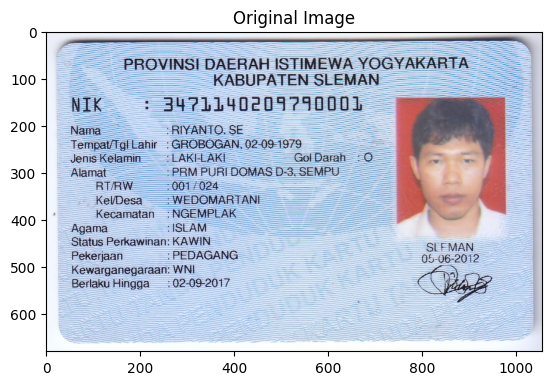

em

PROVINSI DAERAH ISTIMEWA YOGYAKARTA
KABUPATEN SLEMAN

 

NIK : 34711140209790001

Nama :RIYANTO. SE

Tempat/Tgl Lahir : GROBOGAN. 02-09-1979

Jenis Kelamin : LAKI-LAKI Gol Darah : 0

Alamat PRM PURI DOMAS D-3. SEMPU
RTRW 1001 1024

Kel/Desa : WEDOMARTANI!
Kecamatan : NGEMPLAK

Agama "ISLAM
Status Bean KAWIN SLEMAN
Pekerjaan : PEDAGANG 05-06-2012

Kewarganegaraan: WNI HI —
Berlaku Hingga :02-09-2017 NIA

   
 

 


Processing image: ktp1.png


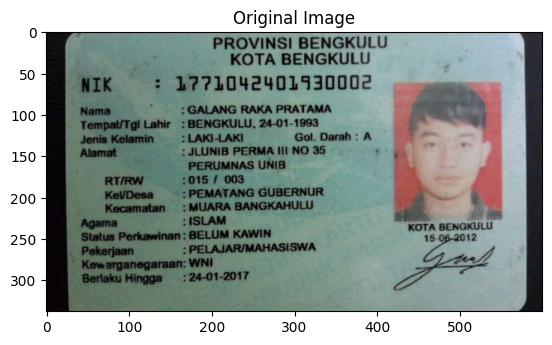

PROVINSI BENGKULU
KOTA BENGKULU

NIK 2 19791012101430002

Nama
Tempat/TgI Lahir
Jenis Kelamin
Alamat

RTRW
KevDesa
Kecamatan

Agama
Status Perkawinan :

Kewarganegaraan:
Berlaku Hingga:

: GALANG RAKA PRATAMA

: BENGKULU, 24-01-1993

# LAKI-LAKI Gol. Darah : A
1 JLUNIB PERMA III NO 35

PERUMNAS UNIB

1015 / 003
: PEMATANG GUBERNUR
: MUARA BANGKAHULU
ISLAM sk
BELUM KAWIN KOTA BENGKULU
: PELAJAR/MAHASISWA —

WNI 212
24-01-2017 AA La


Processing image: ktp2.png


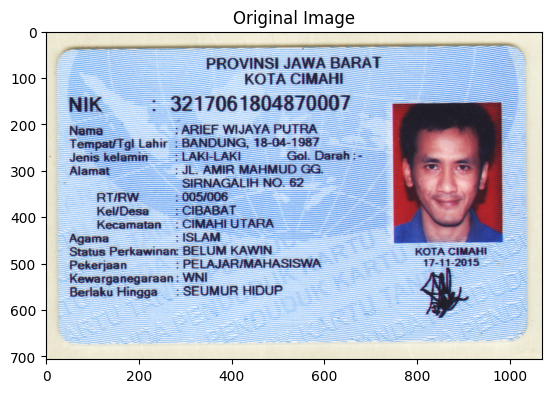

PROVINSI JAWA BARAT

 

KOTA CIMAHI
NIK : 3217061804870007
Nama 1 ARIEF WIJAYA PUTRA
Tempat/Tgi Lahir : BANDUNG, 18-04-1987
Jenis kelamin : LAKI-LAKI Gol. Darah :-
Alamat : JL. AMIR MAHMUD GG.
SIRNAGALIH NO. 62

RT/RW 1005/2006

Kel/Desa : CIBABAT

Kecamatan : CIMAHI UTARA
Agama : ISLAM
Status Perkawinan: BELUM KAWIN KOTA CIMAHI
Pekerjaan : PELAJAR/MAHASISWA 17-11-2015
Kewarganegaraan : WNI

Berlaku Hingga

: SEUMUR HIDUP


Processing image: ktp3.png


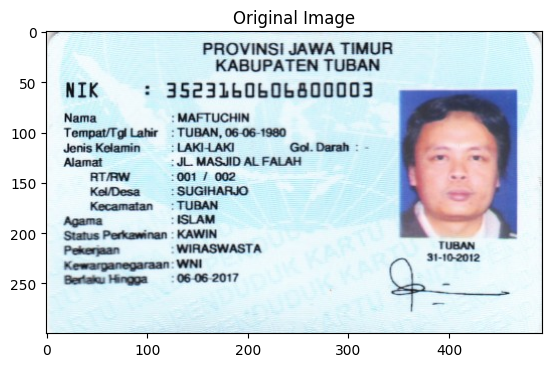

PROVINSI JAWA TIMUR
KABUPATEN TUBAN

NIK: 3523150404800003
Nama MArTUCHIN
Tompat/Tgi Lahir TUBAN, 05.06 1980
Jenis Kolamin LAKI LAKI Got Daran
Mamat IL MASJID AL FALAH
BTAW 0011 002
KolDesa — SUGIHARIO 5 8
Kecamatan — TUBAN
ISLAM 8 Y
Kawi

 

WIRASWASTA tuBAN
kewarganegaraan WNI — Arweoi

Berak Hungga 06 06 2017

 


Processing image: ktp5.png


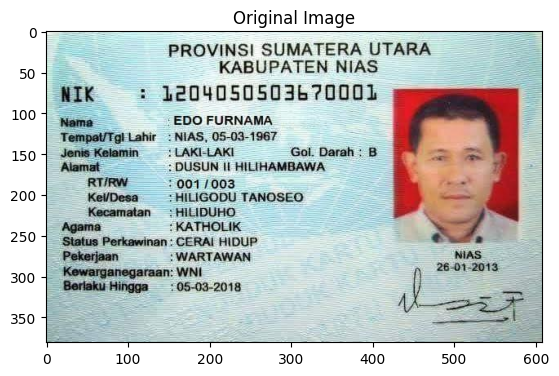

PROVINSI SUMATERA UTARA
KABUPATEN NIAS

NIK 1 12010505036 70001

Nama EDO FURNAMA
Tempat/Tgl Lahir: NIAS, 05-03-1967
Jenis Kelamin: LAKI-LAKI Gol. Darah : B 3:
Alamat : DUSUN II HILIHAMBAWA

RTIRW 001/003

Kel/Desa HILIGODU TANOSEO

Kecamatan : HILIDUHO
Agama KATHOLIK RN 4
Status Perkawinan: CERAI HIDUP Li .
Pekerjaan : WARTAWAN NIAS
Kewarganegaraan: WNI mena aoi
Berlaku Hingga — :05-03-2018 |

——35

8 —
5
|


Processing image: ktp6.png


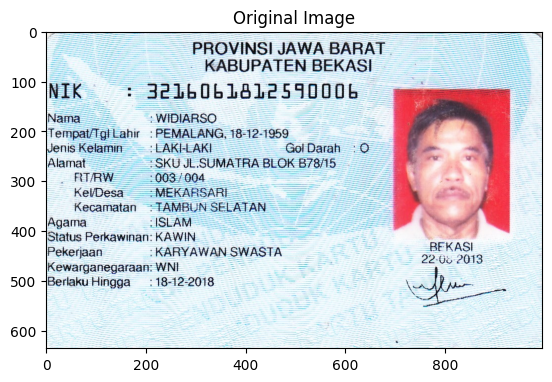

PROVINSI JAWA BARAT
KABUPATEN BEKASI

NIK 1 30160b1012590006 en
Nama : WIDIARSO #
Tempat/Tgl Lahir : PEMALANG, 18-12-1959
Jenis Kelamin : LAKI-LAKI Gol Darah : 0
Alamat :SKU JLLSUMATRA BLOK B78/15
RTRW 0903 004
Kel/Desa : MEKARSARI 3
Kecamatan: TAMBUN SELATAN
Agama :ISLAM
Status Perkawinan: KAWIN
Pekerjaan KARYAWAN SWASTA Aa

22-6u 2013
Kewarganegaraan: WNI tua
Berlaku Hingga :18-12-2018 N Jo

 

-———



In [5]:
class KTPOCR:
    def __init__(self, image_folder):
        self.image_folder = image_folder

    def process_image(self, image_path):
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ## (2) Threshold
        th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)

        ## (3) Detect
        result = pytesseract.image_to_string(threshed, lang="ind")

        final = []

        ## (5) Normalize
        for word in result.split("\n"):
            if "”—" in word:
                word = word.replace("”—", ":")

            # normalize NIK
            if "NIK" in word:
                nik_char = word.split()
            if "?" in word:
                word = word.replace("?", "7")

            final.append(word)

        return final, img

    def display_info(self):
        for filename in os.listdir(self.image_folder):
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(self.image_folder, filename)
                print(f"\nProcessing image: {filename}")
                extracted_data, image = self.process_image(image_path)

                # Display the original image
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title('Original Image')
                plt.show()

                # Display extracted data
                for item in extracted_data:
                    print(item)

if __name__ == "__main__":
    try:
        image_folder = '/mnt/d/Cool Yeah/Semester 5/Mechine Learning/Kuis 2/dataset'
    except:
        image_folder = None
        print('Define your image folder path. Example: python ocr.py /path/of/image/folder')
    if image_folder:
        ocr = KTPOCR(image_folder)
        ocr.display_info()